# Hairstyle recommendations based on face shape

It uses SOTA approach from the [paper](https://lib.jucs.org/article/104490/) "Transfer Learning with EfficientNetV2S for Automatic Face Shape Classification" (28/2/2024) to classify face shapes.

I have made small improvements: used [Multi-task CNN](https://github.com/ipazc/mtcnn) face detector for face detection which enlarged my whole dataset by 18% (4758 images instead of 4034).

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.__version__) 
import tensorflow as tf
import keras_cv

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-05-29 10:41:59.000347: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 10:41:59.246688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 10:41:59.944844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3.3.3


/home/cat/.env/tf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-29 10:42:02.625724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 10:42:02.746009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 10:42:02.746343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load dataset

Be sure to have a Cropped Face Dataset. To make it, refer to file `transformDataset.ipynb`.

Load resized images into training and validation datasets with a 0.2 split and BATCH_SIZE=16

In [3]:
IMAGE_RES = 150
BATCH_SIZE = 16 #32 is for initial fit, 16 for fine-tuning

train_ds, valid_ds = keras.utils.image_dataset_from_directory(
    "augmented_ds/train/",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES, IMAGE_RES),
    validation_split=0.2,
    seed=121,
    subset="both"
)

Found 19112 files belonging to 5 classes.
Using 15290 files for training.
Using 3822 files for validation.


2024-05-29 10:42:03.248186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 10:42:03.248363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 10:42:03.248436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
test_ds = keras.utils.image_dataset_from_directory(
    "augmented_ds/test/",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES, IMAGE_RES)
)

Found 4778 files belonging to 5 classes.


In [5]:
class_names = np.asarray(train_ds.class_names)
NUM_CLASSES = len(class_names)
print(train_ds.class_names)

['Heart', 'Oblong', 'Oval', 'Round', 'Square']


The distribution of images per class

2024-05-29 10:42:06.447860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<BarContainer object of 5 artists>

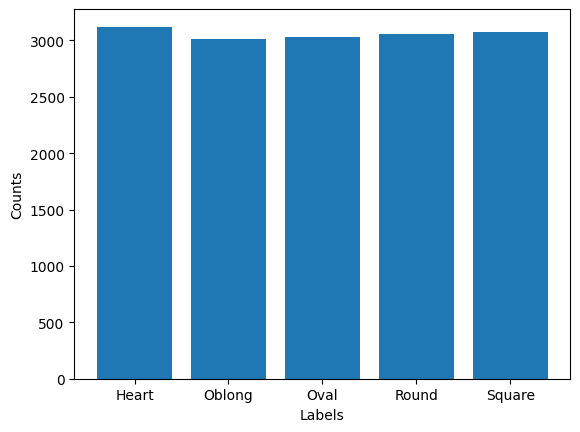

In [6]:
labels = list(train_ds.unbatch().map(lambda x,y: y).as_numpy_iterator())
# print(labels)
classes, counts = np.unique(labels, return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.bar(class_names[classes], counts) 

Examples of the Cropped Face Dataset

In [86]:
def plot_batch(ds, class_names, num=0, predict=False, model=None, img_preprocess=False, image_size = (150, 150)):

    plt.figure(figsize=(10, 10))
    image_batch, label_batch = next(iter(ds.take(1)))
    image_batch = image_batch.numpy().astype(int)
    label_batch = label_batch.numpy()

    if predict:
        if img_preprocess:
            new_image_batch = preprocess_batch(image_batch, image_size)
        else:
            new_image_batch = image_batch
        predicted_batch = model.predict(new_image_batch)
        predicted_ids = np.argmax(predicted_batch, axis=1)

    if num==0:
        num = len(image_batch)   
    for i in range(num):
        ax = plt.subplot(int(np.sqrt(num)), int(np.sqrt(num)), i + 1)
        plt.imshow(image_batch[i])

        if predict:
            color = "blue" if predicted_ids[i] == label_batch[i] else "red"
            plt.title(class_names[predicted_ids[i]] + '(label='+class_names[label_batch[i]]+')', color=color)
        else:
            plt.title(class_names[label_batch[i]], color="blue")
        plt.axis("off")

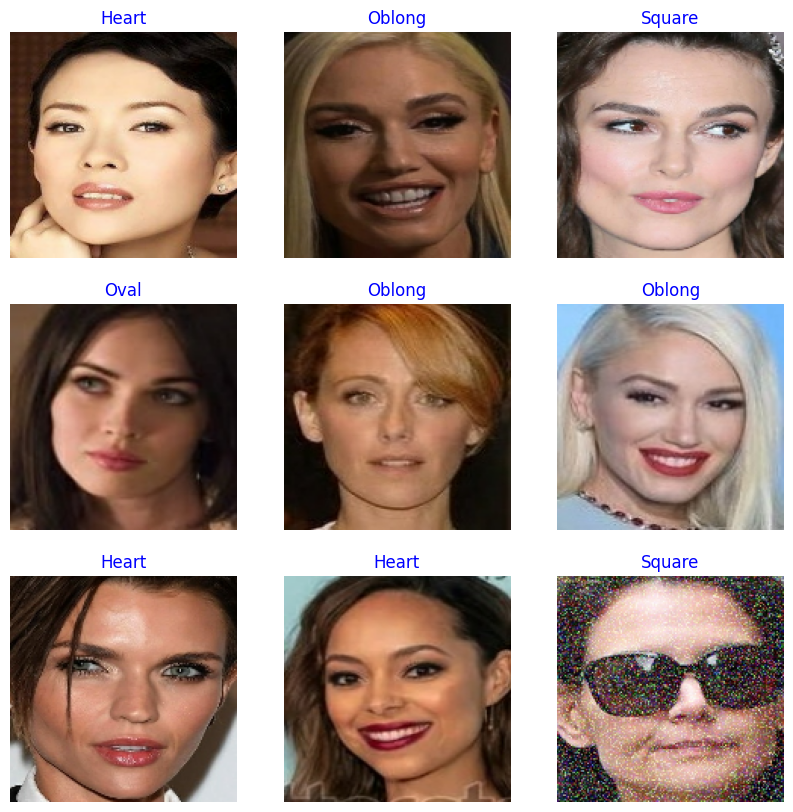

In [8]:
plot_batch(train_ds,class_names,9)

## Data augmentation

I use already augmented dataset as it showed better results than using augmenter only during the training. So I added additional augmentation: 
- random zoom with preserved aspect ratio in the range (-10%, 10%)
- random change of the contrast in the range (-20%, 20%)
- random change of the brightness  in the range (-40%, 40%)

In [9]:
augmenter = keras.Sequential(
    [
        # keras.layers.RandomFlip(mode="horizontal"),
        # keras.layers.RandomRotation(factor=0.08, fill_mode='constant', fill_value=0), # (-50◦, 30◦)
        # keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant', fill_value=0),
        keras.layers.RandomZoom(height_factor=0.1, fill_mode='constant', fill_value=0),
        keras.layers.RandomContrast(factor=0.2),
        keras.layers.RandomBrightness(factor=0.4)
    ],
)

def augment_data(images, labels):
    images = augmenter(images)
    return images, labels

In [10]:
train_batched_dataset = train_ds.map(augment_data).prefetch(1)
valid_batched_dataset = valid_ds.prefetch(1)

test_batches = test_ds.prefetch(1)

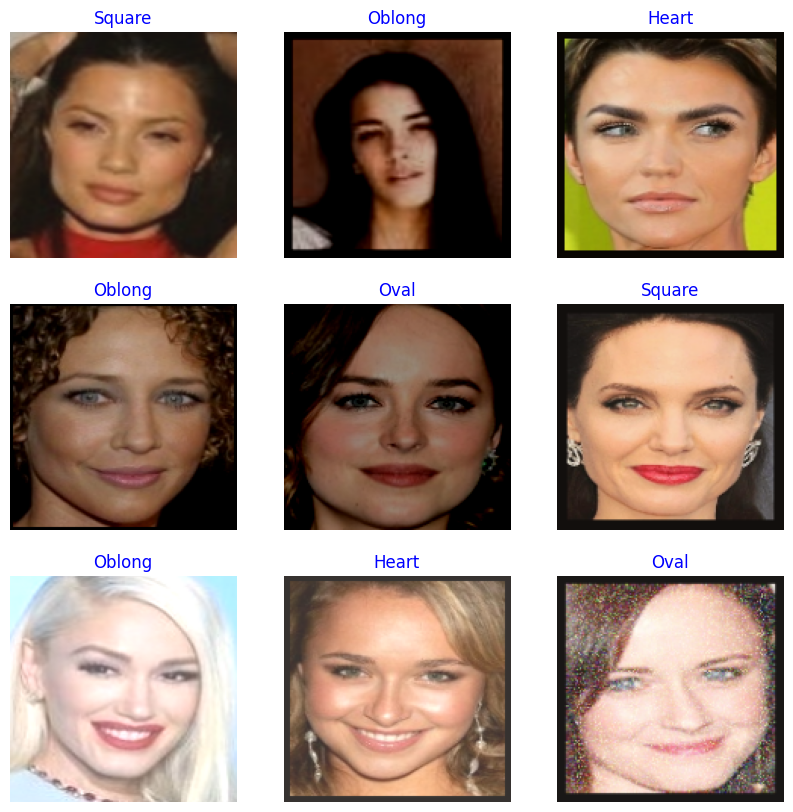

In [11]:
plot_batch(train_batched_dataset,class_names,9)

## Create model and use transfer learning

In [15]:
def create_base_model(input_shape: tuple[int, int, int] = (150, 150, 3),
                      output_shape: int = 5,
                      learning_rate: float = 0.0001,
                      fine_tuning: bool = False,
                      num_layers: int = 0,
                      weights_path: str=None) -> keras.Model:
    
    base_model = keras.applications.EfficientNetV2S(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=input_shape,
        include_top=False,
        pooling='avg',
    )  # Do not include the ImageNet classifier at the top.

    # Freeze the base_model
    for layer in base_model.layers:
        layer.trainable = False
    if fine_tuning:
        for layer in base_model.layers[-num_layers:]:
            layer.trainable = True

    # Create new model on top
    inputs = keras.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

    # EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [0, 255] range. 
    # At the same time, preprocessing as a part of the model (i.e. Rescaling layer) 
    # can be disabled by setting include_preprocessing argument to False. 
    # With preprocessing disabled EfficientNetV2 models expect their inputs 
    # to be float tensors of pixels with values in the [-1, 1] range.
    
    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(inputs, training=False)
    # Regularize with dropout in base fit
    if not fine_tuning:
        x = keras.layers.Dropout(0.2)(x)  
    outputs = keras.layers.Dense(output_shape, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    # load weights for fine-tuning
    if fine_tuning and weights_path is not None:
        model.load_weights(weights_path)

    model.summary(show_trainable=True)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

### Initial fit

I am fitting only the top layer to 5 classes. When it has decent results I can move to fine-tuning n top layers of the EfficientNetV2S. Trainig goes for 100 epochs with learning_rate=0.0001, batch-size=32 and dropout=0.2 in dense layer. The best weights are saved.

In [17]:
model = create_base_model(input_shape=(IMAGE_RES, IMAGE_RES, 3),
                          output_shape=NUM_CLASSES,
                          learning_rate=0.0001,
                          fine_tuning = False)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-s            │ (None, 1280)          │ 20,331,360 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 5)             │      6,405 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,337,765 (77.58 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [18]:
checkpoint_path = ".checkpoints/checkpoint_base_aug.weights.h5"
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=13),
    keras.callbacks.TensorBoard(log_dir='./logs'),
    keras.callbacks.CSVLogger('./logs/base_aug.log', append=True),
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                    save_weights_only=True, # set to False to save the entire model
                                    save_best_only=True, # save only the best model weights instead of a model every epoch
                                    save_freq="epoch", # save every epoch
                                    verbose=1)
]

In [19]:
initial_epochs = 100 

history = model.fit(train_batched_dataset, 
                    epochs=initial_epochs, 
                    validation_data=valid_batched_dataset, 
                    callbacks=my_callbacks)

Epoch 1/100


/home/cat/.env/tf_env/lib/python3.10/site-packages/keras/src/callbacks/tensorboard.py:668: UserWarning: Model failed to serialize as JSON. Ignoring... SparseCategoricalAccuracy.get_config() missing 1 required positional argument: 'self'
  warnings.warn(f"Model failed to serialize as JSON. Ignoring... {exc}")
I0000 00:00:1716823968.810793   41750 service.cc:145] XLA service 0x7f3868002910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716823968.810830   41750 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-05-27 17:32:49.273326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-27 17:32:50.723054: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716824009.906078   41750 device_compiler.h:188] Compiled cluster using XLA!

478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 1.6236 - sparse_categorical_accuracy: 0.2337

I0000 00:00:1716824088.950325   42600 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4227', 124 bytes spill stores, 124 bytes spill loads

I0000 00:00:1716824089.014662   42594 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4227', 340 bytes spill stores, 340 bytes spill loads

I0000 00:00:1716824100.163559   42637 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4227', 172 bytes spill stores, 172 bytes spill loads




Epoch 1: val_loss improved from inf to 1.52390, saving model to .checkpoints/checkpoint_base_aug.weights.h5
478/478 ━━━━━━━━━━━━━━━━━━━━ 147s 202ms/step - loss: 1.6236 - sparse_categorical_accuracy: 0.2337 - val_loss: 1.5239 - val_sparse_categorical_accuracy: 0.3307
Epoch 2/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.5451 - sparse_categorical_accuracy: 0.2944
Epoch 2: val_loss improved from 1.52390 to 1.47917, saving model to .checkpoints/checkpoint_base_aug.weights.h5
478/478 ━━━━━━━━━━━━━━━━━━━━ 44s 91ms/step - loss: 1.5450 - sparse_categorical_accuracy: 0.2945 - val_loss: 1.4792 - val_sparse_categorical_accuracy: 0.3647
Epoch 3/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.4959 - sparse_categorical_accuracy: 0.3395
Epoch 3: val_loss improved from 1.47917 to 1.44899, saving model to .checkpoints/checkpoint_base_aug.weights.h5
478/478 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - loss: 1.4959 - sparse_categorical_accuracy: 0.3395 - val_loss: 1.4490 - val_sparse_categoric

In [20]:
model_ev = model.evaluate(test_batches)
model_ev

149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.2071 - sparse_categorical_accuracy: 0.5275

I0000 00:00:1716828869.056439   55445 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4227', 148 bytes spill stores, 148 bytes spill loads



150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 1.2071 - sparse_categorical_accuracy: 0.5275


[1.2078605890274048, 0.528254508972168]

In [24]:
model.save('base_augmented.keras')
model.save_weights('base_aug.weights.h5')

In [5]:
def plot_hist(hist, fine_tune_epochs=None, fine_tune_titles = None):
    acc = hist['sparse_categorical_accuracy']
    val_acc = hist['val_sparse_categorical_accuracy']

    loss = hist['loss']
    val_loss = hist['val_loss']

    epochs_range = range(len(hist['loss']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    if fine_tune_epochs:
        for init_ep,label in zip(fine_tune_epochs, fine_tune_titles):
            label = label if fine_tune_titles else 'Fine Tuning at '+ str(init_ep) + 'epoch'
            plt.plot([init_ep-1, init_ep-1],
                    plt.ylim(), label=label)
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    if fine_tune_epochs:
        for init_ep,label in zip(fine_tune_epochs, fine_tune_titles):
            label = label if fine_tune_titles else 'Fine Tuning at '+ str(init_ep) + 'epoch'
            plt.plot([init_ep-1, init_ep-1],
                    plt.ylim(), label=label)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig('output.png')

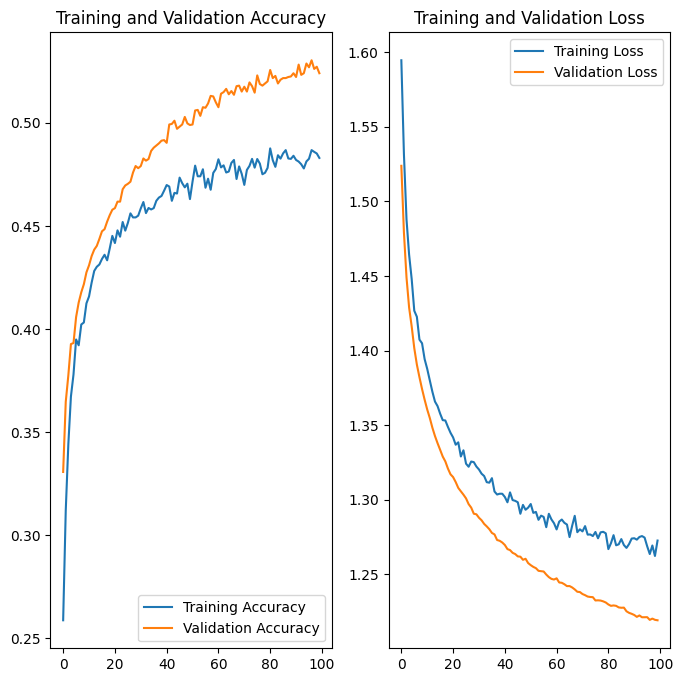

<Figure size 640x480 with 0 Axes>

In [7]:
import pandas
df = pandas.read_csv('./logs/base_aug.log')
plot_hist(df)

### Fine-tuning top layer with the 7th stage of EfficientNetV2S

After achieving 0.52 test accuracy I decided to fine-tune also last stage of EfficientNetV2S. Best weight are saved to separate checkpoint file. After training for 169 epochs test accuracy has raised up to 0.9. It is a great improvement.

In [13]:
model = create_base_model(input_shape=(IMAGE_RES, IMAGE_RES, 3),
                          output_shape=NUM_CLASSES,
                          learning_rate=0.0001,
                          fine_tuning = True,
                          num_layers=4,
                          weights_path='.checkpoints/checkpoint_base_aug.weights.h5')

checkpoint_path = ".checkpoints/checkpoint_fine-tune_aug.weights.h5"
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=13),
    keras.callbacks.TensorBoard(log_dir='./logs'),
    keras.callbacks.CSVLogger('./logs/fine-tune_aug.log', append=True),
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                    save_weights_only=True, # set to False to save the entire model
                                    save_best_only=True, # save only the best model weights instead of a model every epoch
                                    save_freq="epoch", # save every epoch
                                    verbose=1)
]

initial_epochs = 500 #100, 500

history = model.fit(train_batched_dataset, 
                    epochs=initial_epochs, 
                    validation_data=valid_batched_dataset, 
                    callbacks=my_callbacks)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-s            │ (None, 1280)          │ 20,331,360 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 5)             │      6,405 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,337,765 (77.58 MB)

 Trainable params: 336,645 (1.28 MB)

 Non-trainable params: 20,001,120 (76.30 MB)

Epoch 1/500


I0000 00:00:1716886014.983673    5550 service.cc:145] XLA service 0x7ae2cc001510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716886014.983855    5550 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-05-28 10:46:55.408543: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-28 10:47:01.261618: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716886044.295682    5885 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_23329', 124 bytes spill stores, 124 bytes spill loads

I0000 00:00:1716886062.513552    5550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


954/956 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.2395 - sparse_categorical_accuracy: 0.5013

I0000 00:00:1716886157.808853    5954 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_23329', 148 bytes spill stores, 148 bytes spill loads



956/956 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.2395 - sparse_categorical_accuracy: 0.5013

I0000 00:00:1716886189.105808    6074 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4227', 172 bytes spill stores, 172 bytes spill loads




Epoch 1: val_loss improved from inf to 1.12987, saving model to .checkpoints/checkpoint_fine-tune_aug.weights.h5
956/956 ━━━━━━━━━━━━━━━━━━━━ 195s 139ms/step - loss: 1.2395 - sparse_categorical_accuracy: 0.5013 - val_loss: 1.1299 - val_sparse_categorical_accuracy: 0.5576
Epoch 2/500
955/956 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.1691 - sparse_categorical_accuracy: 0.5368
Epoch 2: val_loss improved from 1.12987 to 1.06412, saving model to .checkpoints/checkpoint_fine-tune_aug.weights.h5
956/956 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - loss: 1.1691 - sparse_categorical_accuracy: 0.5369 - val_loss: 1.0641 - val_sparse_categorical_accuracy: 0.5877
Epoch 3/500
955/956 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.1136 - sparse_categorical_accuracy: 0.5609
Epoch 3: val_loss improved from 1.06412 to 1.00694, saving model to .checkpoints/checkpoint_fine-tune_aug.weights.h5
956/956 ━━━━━━━━━━━━━━━━━━━━ 51s 53ms/step - loss: 1.1135 - sparse_categorical_accuracy: 0.5609 - val_loss: 1.0069 - val_s

In [15]:
model_ev = model.evaluate(test_batches)
model_ev

299/299 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.3021 - sparse_categorical_accuracy: 0.9003


[0.28632980585098267, 0.9030975103378296]

In [16]:
model.save('fine_tune1_aug.keras')
model.save_weights('fine_tune1_aug.weights.h5')

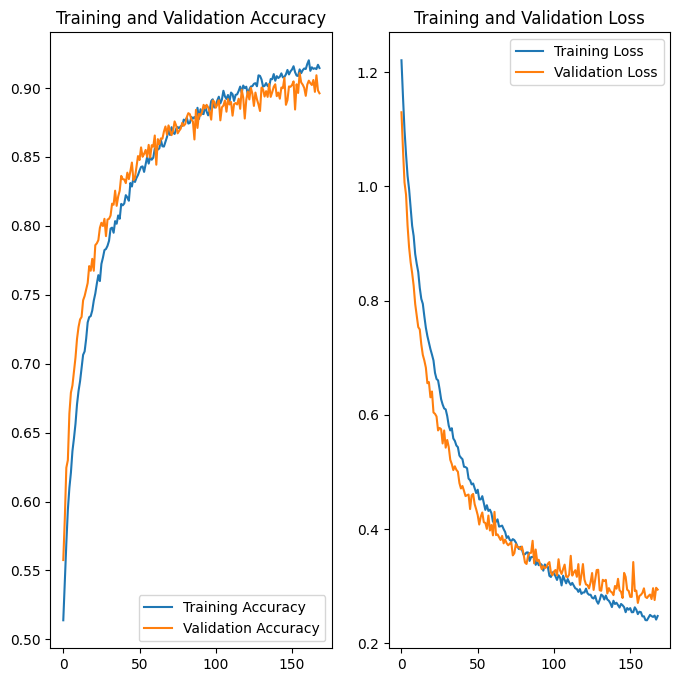

In [92]:
df = pandas.read_csv('./logs/fine-tune_aug.log')
plot_hist(df)

### Fine-tuning top layer with the 6th and 7th stages of EfficientNetV2S

0.9 test accuracy is good, but in the paper "Transfer Learning with EfficientNetV2S for Automatic Face Shape Classification" was achieved validation accuracy of 0.9632. So I decided to fine-tune additionaly the 6th stage of EfficientNetV2S and my results are fantastic: test loss is 0.0973 and test accuracy is 0.9736

In [16]:
model = create_base_model(input_shape=(IMAGE_RES, IMAGE_RES, 3),
                          output_shape=NUM_CLASSES,
                          learning_rate=0.0001,
                          fine_tuning = True,
                          num_layers=227, # this version of EfficientNetV2S has more than 500 layers
                          weights_path='.checkpoints/checkpoint_fine-tune_aug.weights.h5')

checkpoint_path = ".checkpoints/checkpoint_fine-tune_block6_aug.weights.h5"
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=13),
    keras.callbacks.TensorBoard(log_dir='./logs'),
    keras.callbacks.CSVLogger('./logs/fine-tune_block6_aug.log', append=True),
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                    save_weights_only=True, # set to False to save the entire model
                                    save_best_only=True, # save only the best model weights instead of a model every epoch
                                    save_freq="epoch", # save every epoch
                                    verbose=1)
]

epochs = 500 #100, 500

history = model.fit(train_batched_dataset, 
                    epochs=epochs,
                    initial_epoch=169,
                    validation_data=valid_batched_dataset, 
                    callbacks=my_callbacks)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-s            │ (None, 1280)          │ 20,331,360 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 5)             │      6,405 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,337,765 (77.58 MB)

 Trainable params: 14,898,477 (56.83 MB)

 Non-trainable params: 5,439,288 (20.75 MB)

Epoch 170/500


I0000 00:00:1716973694.542096    6119 service.cc:145] XLA service 0x7702400026f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716973694.542139    6119 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-05-29 11:08:15.535237: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-29 11:08:18.673102: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716973723.258082    6974 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31894', 124 bytes spill stores, 124 bytes spill loads

I0000 00:00:1716973760.935587    6119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


955/956 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.1388 - sparse_categorical_accuracy: 0.6181

I0000 00:00:1716973871.283493   11098 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31894', 148 bytes spill stores, 148 bytes spill loads



956/956 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1.1386 - sparse_categorical_accuracy: 0.6182

I0000 00:00:1716973919.662739   11400 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4227', 172 bytes spill stores, 172 bytes spill loads




Epoch 170: val_loss improved from inf to 0.50582, saving model to .checkpoints/checkpoint_fine-tune_block6_aug.weights.h5
956/956 ━━━━━━━━━━━━━━━━━━━━ 252s 172ms/step - loss: 1.1383 - sparse_categorical_accuracy: 0.6182 - val_loss: 0.5058 - val_sparse_categorical_accuracy: 0.8260
Epoch 171/500
956/956 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.5105 - sparse_categorical_accuracy: 0.8153
Epoch 171: val_loss improved from 0.50582 to 0.40038, saving model to .checkpoints/checkpoint_fine-tune_block6_aug.weights.h5
956/956 ━━━━━━━━━━━━━━━━━━━━ 90s 94ms/step - loss: 0.5104 - sparse_categorical_accuracy: 0.8153 - val_loss: 0.4004 - val_sparse_categorical_accuracy: 0.8585
Epoch 172/500
956/956 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3412 - sparse_categorical_accuracy: 0.8751
Epoch 172: val_loss improved from 0.40038 to 0.28961, saving model to .checkpoints/checkpoint_fine-tune_block6_aug.weights.h5
956/956 ━━━━━━━━━━━━━━━━━━━━ 96s 100ms/step - loss: 0.3411 - sparse_categorical_accuracy: 0

In [17]:
model_ev = model.evaluate(test_batches)
model_ev

299/299 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.9713


[0.09732165187597275, 0.9736291170120239]

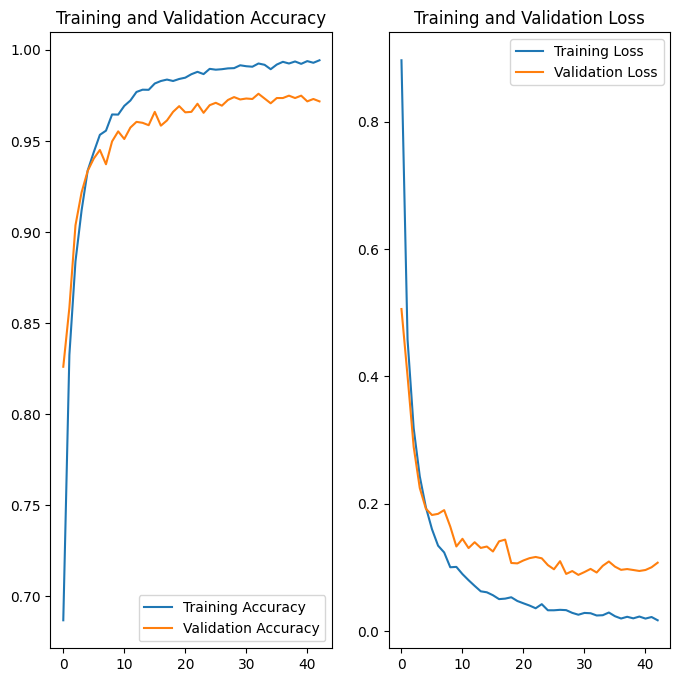

In [93]:
df = pandas.read_csv('./logs/fine-tune_block6_aug.log')
plot_hist(df)

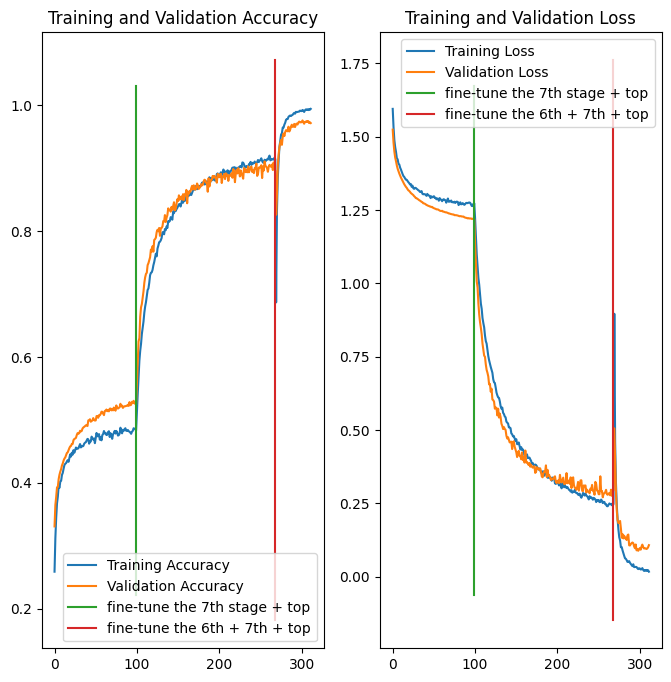

<Figure size 640x480 with 0 Axes>

In [6]:
df = pandas.read_csv('./logs/base_aug.log')
df2 = pandas.read_csv('./logs/fine-tune_aug.log')
df3 = pandas.read_csv('./logs/fine-tune_block6_aug.log')
df_max = pandas.concat([df, df2, df3])
initial_epochs=[df.shape[0], df.shape[0]+df2.shape[0]]
fine_tune_titles = ['fine-tune the 7th stage + top', 'fine-tune the 6th + 7th + top']
plot_hist(df_max, fine_tune_epochs=initial_epochs, fine_tune_titles=fine_tune_titles)

In [18]:
model.save('fine_tune_block6_aug.keras')
model.save_weights('fine_tune_block6_aug.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


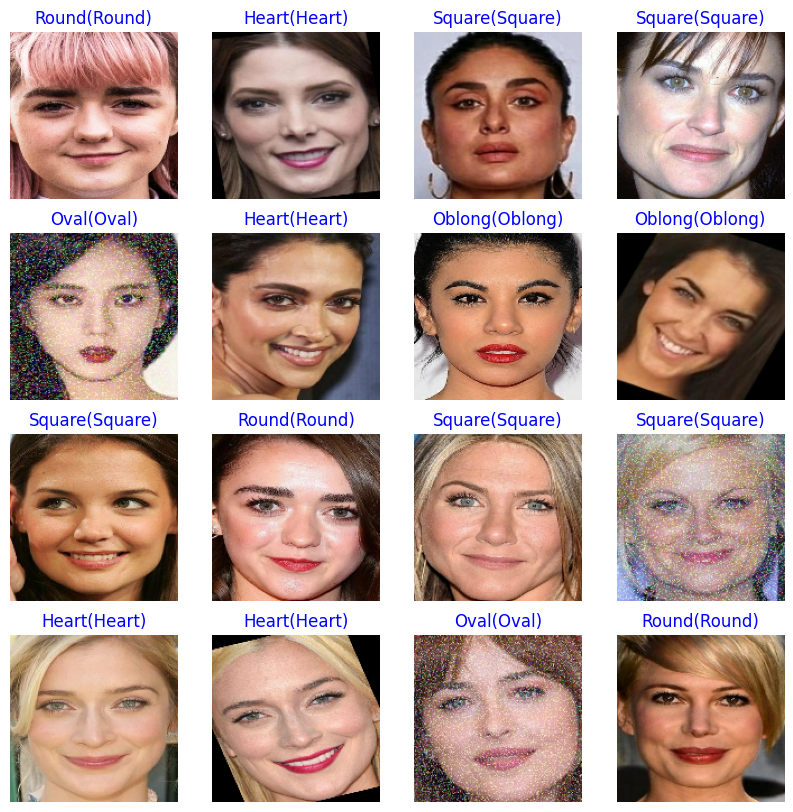

In [82]:
plot_batch(test_batches, class_names, 16, True, model)

## Prediction pipeline

In [73]:
# load test images from the original dataset with preserved aspect ratio

IMAGE_RES = 512
BATCH_SIZE = 9

predict_ds = keras.utils.image_dataset_from_directory(
    "shapeofyou-2/test/",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES, IMAGE_RES),
    pad_to_aspect_ratio=True

)

Found 475 files belonging to 5 classes.


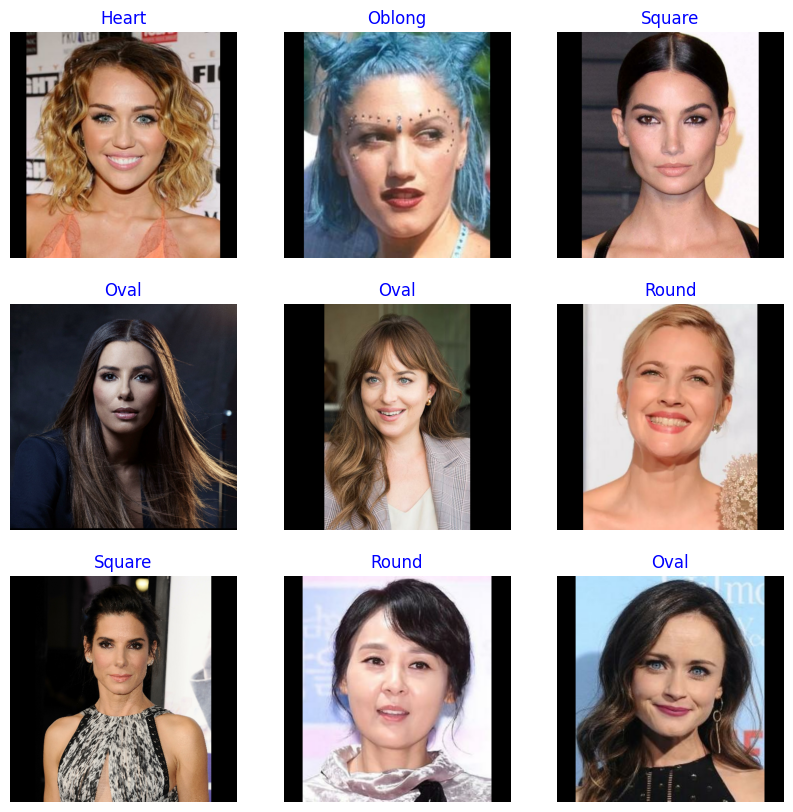

In [85]:
plot_batch(predict_ds,class_names)

Preprocess each image for model prediction:
- detect face
- crop face
- resize face to (150, 150)

In [70]:
from mtcnn import MTCNN

def preprocess_batch(batch, img_size = (150, 150)):
    batch = batch.astype('float32')
    detector = MTCNN()
    min_conf = 0.9
    offset = 20
    new_batch = []

    for img in batch:
        h,w,ch = img.shape
        area = 0
        final_face = None
        detections = detector.detect_faces(img)

        # transform only face with the biggest area 
        for det in detections:
            if det['confidence'] >= min_conf:
                x, y, width, height = det['box']
                object = img[max(y-offset,0):min(y+height+offset,h), max(0,x-offset):min(w,x+width+offset), :]
                object_area = object.shape[0]*object.shape[1]
                if (object_area > area):
                    area = object_area
                    final_face = object
        final_face = cv2.resize(final_face, img_size)
        new_batch.append(final_face.astype(int))
    results_tensor = tf.stack(new_batch)
    print(results_tensor.shape)
    return results_tensor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


(-0.5, 149.5, 149.5, -0.5)

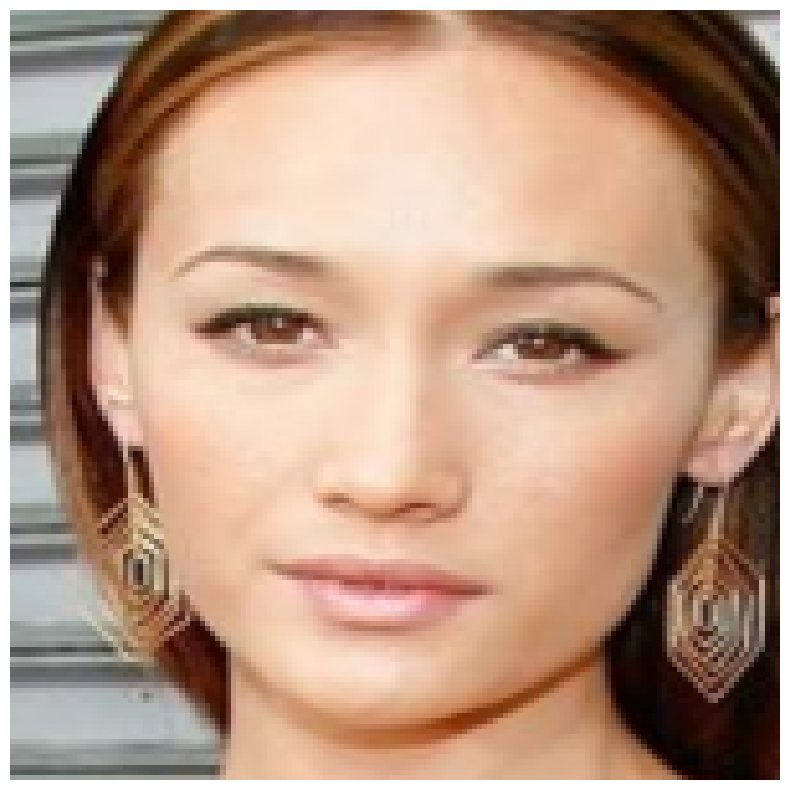

In [58]:
image_batch, label_batch = next(iter(predict_ds.take(1)))
image_batch = image_batch.numpy().astype('float32')
t_image_batch = transform_batch(image_batch, (IMAGE_RES, IMAGE_RES))
plt.figure(figsize = (10,10))
plt.imshow(t_image_batch[0])
plt.axis('off')

## Prediction results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━

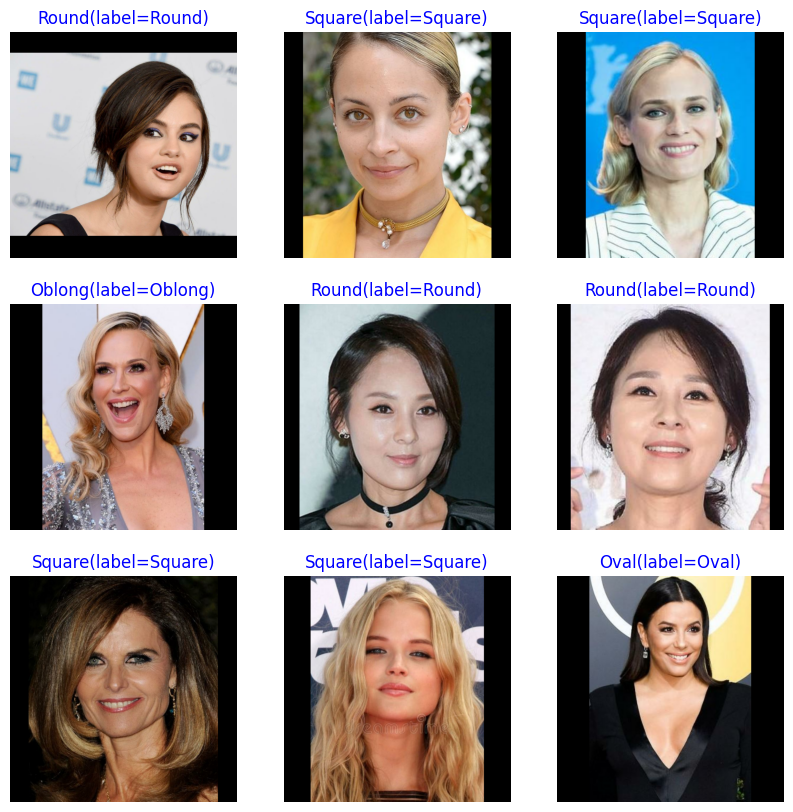

In [87]:
plot_batch(predict_ds, class_names, predict=True, model=model, img_preprocess = True)